In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from tqdm import tqdm
from torch.nn import functional as F
from context_compression.model import GPT, GPTConfig
from context_compression.attn import AttentionKind
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "Hello, I'm a language model," # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 10 # number of samples to draw
max_new_tokens = 256 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# init from a model saved in a specific directory

def mup_GPT(config):
    model = GPT(config)
    base_config = GPTConfig(**{**config.__dict__, "n_head": 12, "head_dim": 64, "n_embd": 64*12, "mup": True})
    base_model = GPT(base_config)
    from mup import set_base_shapes
    set_base_shapes(model, base_model)
    return model

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/selective_run_0_continued/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/selective_run_0_continued/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/memory_loss_run_0/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELF, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/unselective_run_0/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304))
# ckpt_path = "/root/.cache/huggingface/hub/models--Yorth--selective1/snapshots/1d3d987c90be4b8d6f58de60749ba5823f0ecd29/model.pt"

from huggingface_hub import hf_hub_download
# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304,n_head=13)
# model = GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="self_to_selective_run_0_restarted/model_02499.pt")
# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304,n_head=13)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="protection_none_torch_compile/model_02499.pt")
# new_eps_ratios, new_eps_losses = get_validation_loss_at_diff_ratios(new_config, ckpt_path)

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304)
# model = GPT(config)
# ckpt_path = hf_hub_download(repo_id="Yorth/selective1",filename="model.pt")

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True)
# model = mup_GPT(config)
# ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="12_head_baseline_lr_30e-4_head_dim_22_fixed/model_04374.pt")

from context_compression.attn import SelectionHeadLinearComboKind
config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False,n_head=12,head_dim=22,n_embd=22*12,block_size=256,mup=True,selection_head_linear_combo=SelectionHeadLinearComboKind.N_LATENT_MASKS,n_latent_masks=1)
model = mup_GPT(config)
ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="logs/repro_selective_pattern_rankings/12_mini_head_one_mask_per_head_1_latent_mask_10e-4_seed_1339/model_04374.pt")


checkpoint = torch.load(ckpt_path, map_location=device)

state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)


/tmp/ipykernel_23035/1168195439.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


<All keys matched successfully>

In [2]:
# Tokenize input text using GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")
text = "the real problem with traditional dental veneers has little to do with how they function or their performance . who determines what a normal , aesthetically pleasing smile looks like is the real issue . america struggled for decades with defining “ image ” as a marketplace bent on exploiting peoples ’ flaws for economic gain . the danger of this national obsession has become systemic since the days of twiggy . fashion magazines offer photoshopped perfection as the standard to which we should aspire . the effects of this insidious marketing made their way into breast implants and the definition of a hollywood smile . carving their bodies and their teeth , people use their resources to chase a false picture of their “ perfect ” self . people make investments in the tens of thousands of dollars at their dentist office to get the “ perfect ” smile . this message has become so endemic that people with nice smiles are convinced only a “ perfect ” hollywood smile is acceptable . one particularly relevant example of this is highlighted in a june 2015 article entitled “ saving jane ’ s smile . ” gary nankin , dds discusses how he “ saved ” the smile of a patient who was not content with her first set of # porcelain veneers . 1 . endodontic referral for treatment of tooth number 15 , followed by a composite core build - up . 2 . periodontal therapy in both the anterior region and upper left to achieve optimal tissue health . 4 . preparation of maxillary teeth and placement of permanent restorations . 5 . placement of dental implant by the periodontist followed by preparation of mandibular teeth and placement of permanent restorations . 6 .  restore the now fully - healed and osseointegrated implant in the position of tooth number 30 . regarding a person ’ s smile , the strong link to self - esteem and self - worth make an imperfect set of teeth a concern . however , the picture in the article clearly illustrates what appears to be a well - constructed and healthy - looking smile . the entire premise is puzzling . how does a dentist promote “ saving ” a smile that 97 % of the people in america would love to show off ? "
tokens = enc.encode(text)[:256]
tokens = torch.tensor(tokens).unsqueeze(0).to(device) # Add batch dimension and move to device
y = torch.roll(tokens, -1, dims=1)
y[:,-1] = -100

ff_cache = []

model.to(device)

# Run through model
with torch.no_grad():
    with ctx:
        logits, loss, losses = model(tokens,y,ff_cache=ff_cache)
        
print(f"Output logits shape: {logits.shape}")
print("Loss:", loss)

Output logits shape: torch.Size([1, 256, 50257])
Loss: tensor(4.9160, device='cuda:0')


12 256 256
Mean mask value: 76.3391
Std dev of mask values: 209.0577


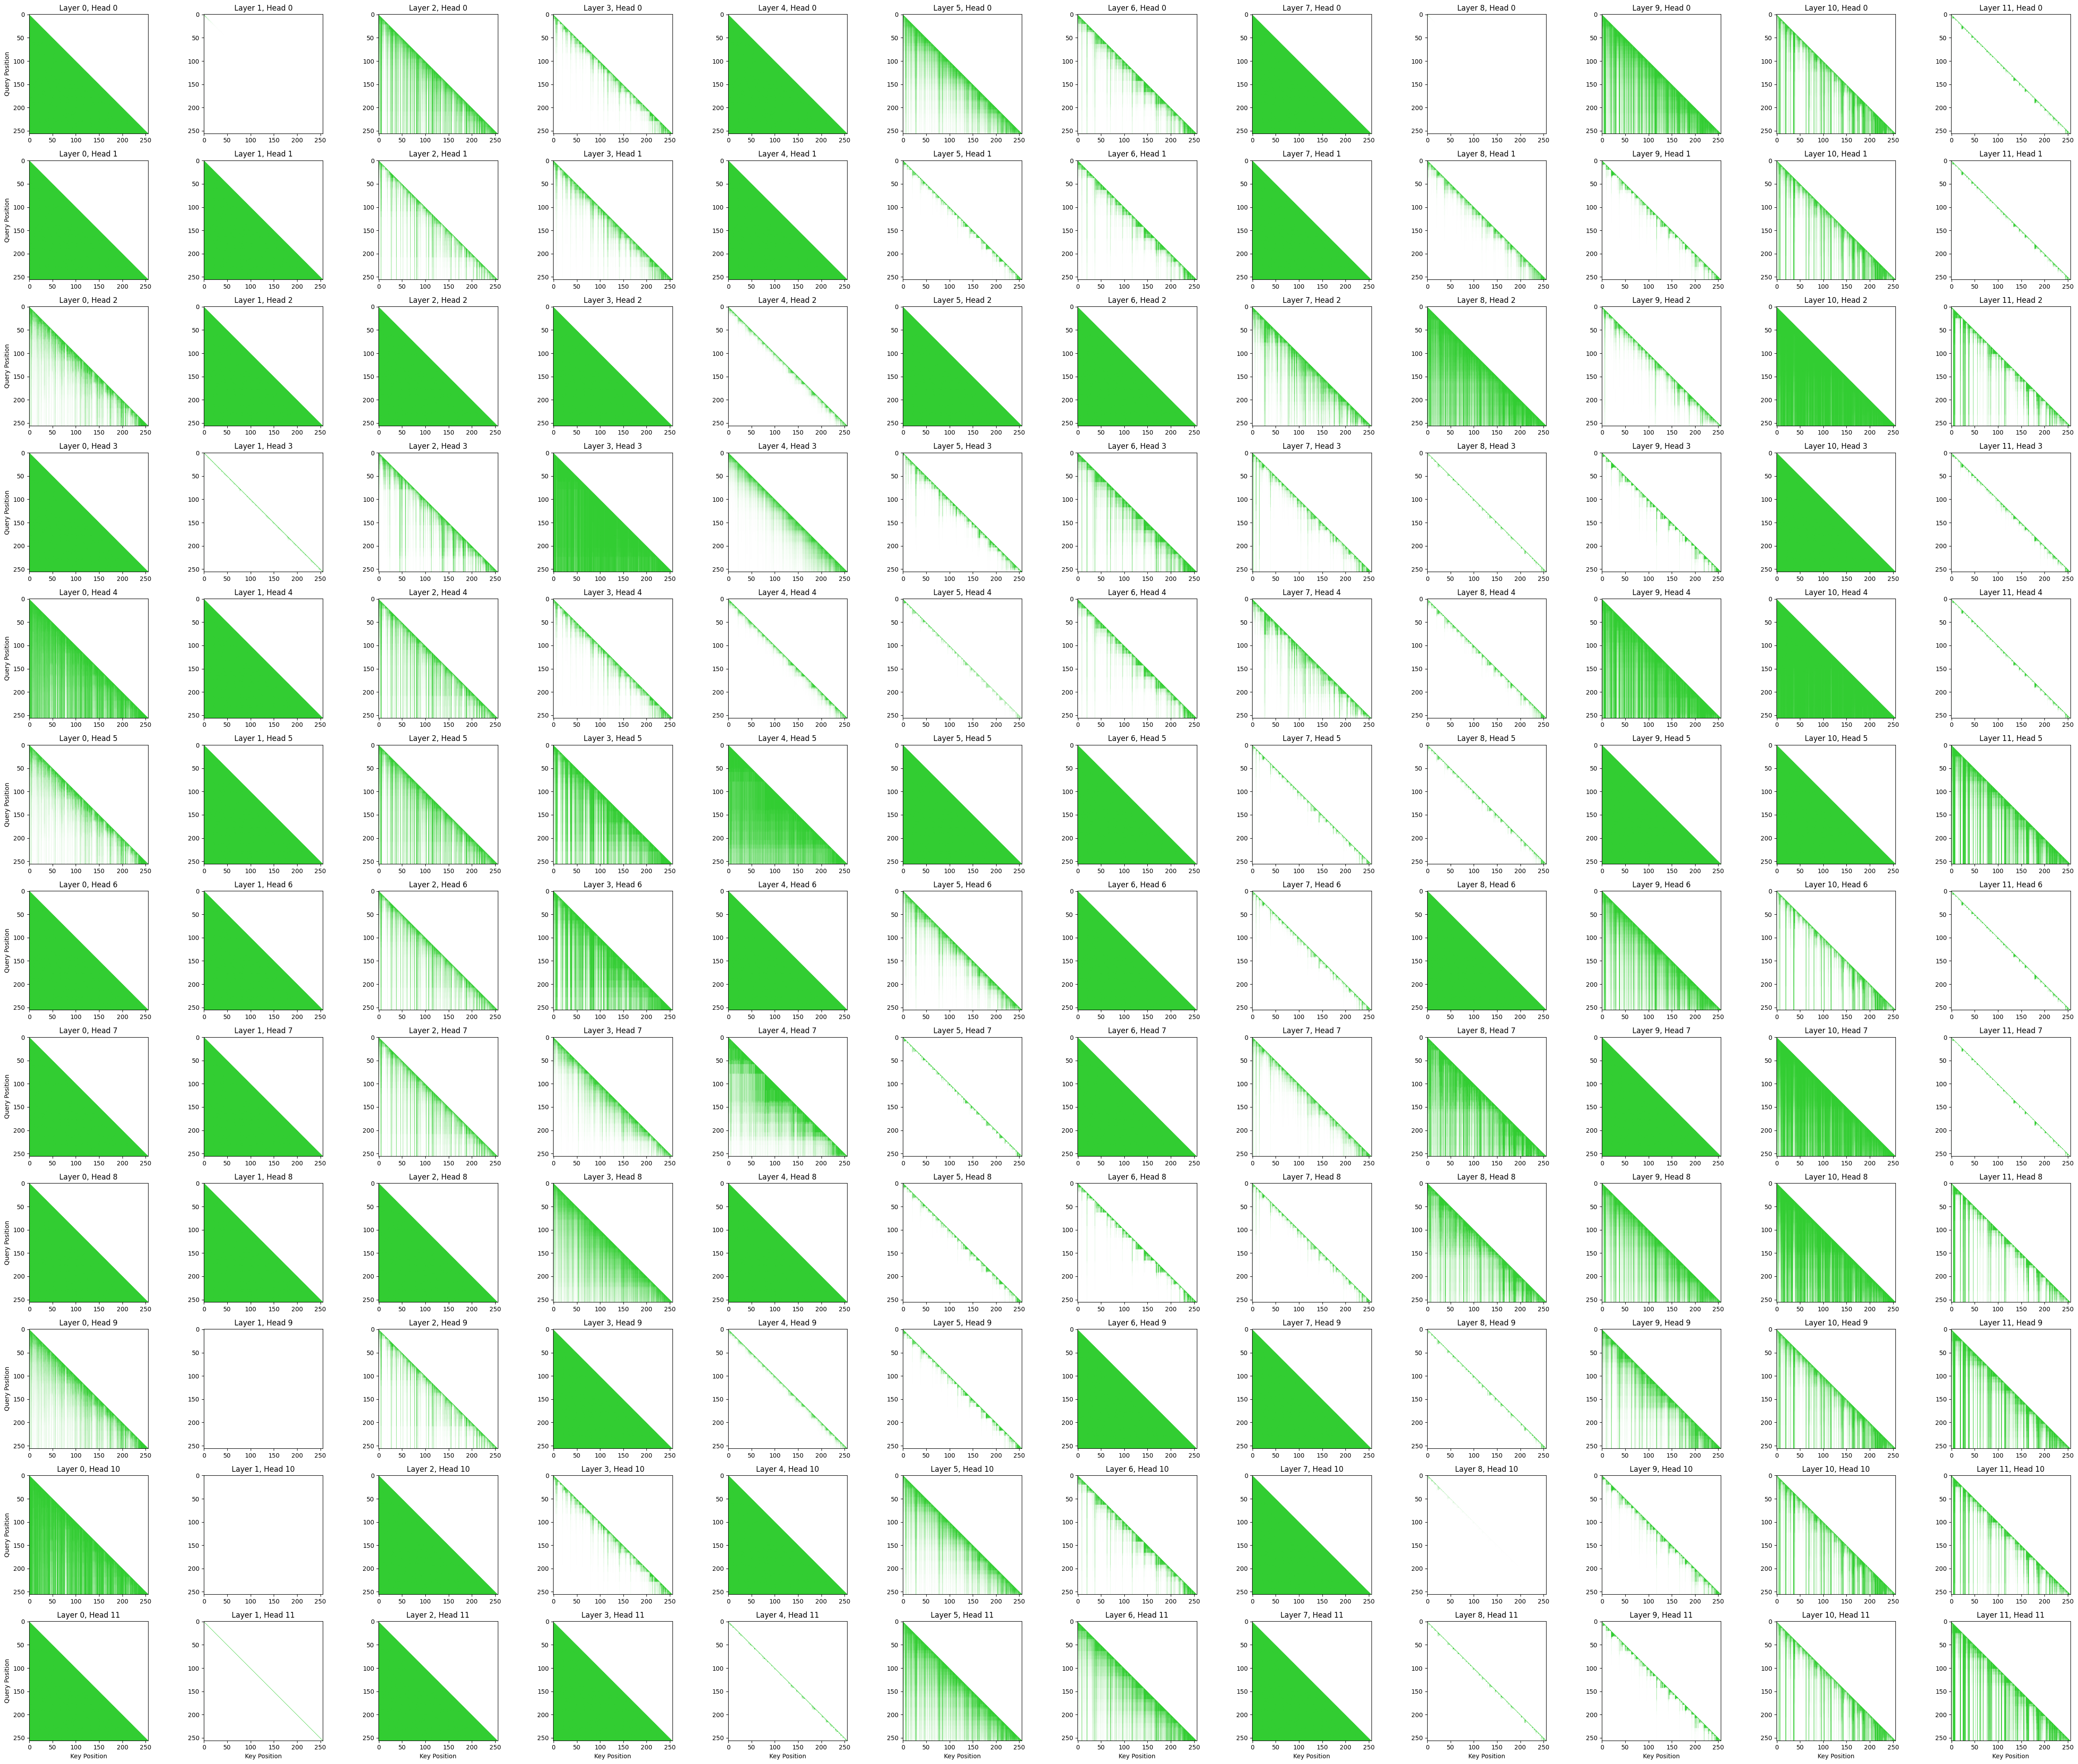

In [6]:
nh,T,Tp = ff_cache[0].squeeze(0).shape
print(nh,T,Tp)

# Plot the attention masks as a bitmap
import matplotlib.pyplot as plt

# Take the first layer's mask from the first batch
mask = ff_cache[6].squeeze(0)  # Shape: [T,Tp]

# plt.figure(figsize=(10,10))
# plt.imshow(-mask, cmap='viridis', aspect='equal')
# plt.colorbar(label='Mask Value')
# plt.title('Attention Mask')
# plt.xlabel('Key Position')
# plt.ylabel('Query Position') 
# plt.show()
import numpy as np

# Calculate mean and standard deviation across all layers
all_masks = np.array([layer_mask[0,0,-1] for layer_mask in ff_cache])
mean_mask = np.mean(all_masks)
std_mask = np.std(all_masks)
print(f"Mean mask value: {mean_mask:.4f}")
print(f"Std dev of mask values: {std_mask:.4f}")

import matplotlib.colors as mcolors

# Create a custom colormap that goes from white (for 0) to light green (for 3)
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_white_lightgreen", ["white", "limegreen"])

# Use this colormap when displaying the mask, with vmin=0 and vmax=3

# # Optionally plot masks from all layers
n_layers = len(ff_cache)
n_heads = 12  # Now we have 12 heads per layer
fig, axes = plt.subplots(n_heads, n_layers, figsize=(4*n_layers, 10*n_heads/3))

for layer_idx, layer_mask in enumerate(ff_cache):
    for head_idx in range(n_heads):
        mask = layer_mask[0, head_idx]  # Take first batch, head_idx head
        
        is_kept_mask = torch.ones_like(torch.tensor(mask))
        is_kept_mask[torch.triu(torch.ones_like(torch.tensor(mask))) == 1] = 0
        is_kept_mask *= torch.exp(-1 * torch.tensor(mask))
        
        axes[head_idx, layer_idx].imshow(is_kept_mask, cmap=custom_cmap, aspect='equal')
        axes[head_idx, layer_idx].set_title(f'Layer {layer_idx}, Head {head_idx}')
        
        # Only add x-labels for the bottom row
        if head_idx == n_heads - 1:
            axes[head_idx, layer_idx].set_xlabel('Key Position')
        
        # Only add y-labels for the leftmost column
        if layer_idx == 0:
            axes[head_idx, layer_idx].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

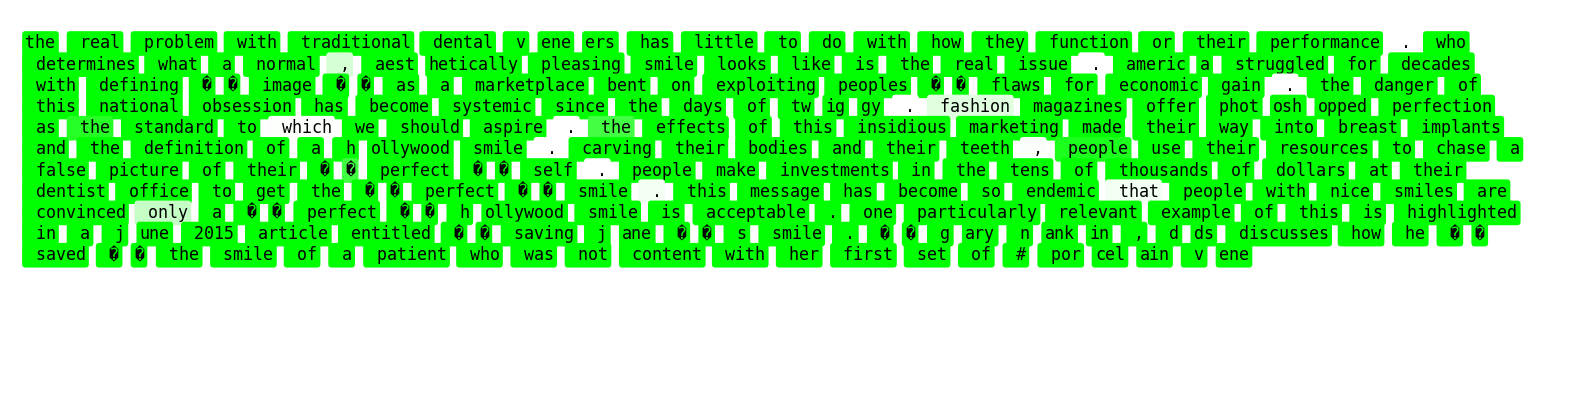

In [17]:
import textwrap
import matplotlib.pyplot as plt

tokens = enc.encode(text)
text_per_token = enc.decode_batch([[i] for i in tokens])

ff_layer = 9
score_per_token = ff_cache[ff_layer][0,0,-1]

tokens_with_scores = list(zip(text_per_token, score_per_token))

import matplotlib.pyplot as plt

# Create a new figure and hide axes
fig, ax = plt.subplots(figsize=(20, 5))
ax.axis("off")

# Starting normalized coordinates (in axis fraction)
x, y = 0.01, 0.9
line_height = 0.055   # Vertical step when wrapping
space_width = 0.01  # Space between tokens

import math
# Iterate through tokens and display each with background color based on its score
for token, score in tokens_with_scores:
    clamp = lambda x: max(0, min(1, x))
    # Normalize the score: score=0 will yield fraction=0, highest score yields fraction=1.
    fraction = 1 - math.exp(-1 * score)
    # Interpolate between green (score=0 --> (0,1,0)) and white (highest score --> (1,1,1))
    color = (fraction, 1, fraction)
    
    # Estimate width for the token text (tweak the scaling factor as needed)
    token_width = 0.0125 / 2 * len(token)
    
    # If the token cannot fit in the current line, wrap to the next line
    if x + token_width > 0.98:
        x = 0.01
        y -= line_height
    
    # Draw the token text with a colored background (using a rounded bbox for aesthetics)
    ax.text(x, y, token, transform=ax.transAxes, fontsize=12, fontfamily="monospace",
            bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # Update x position for the next token
    x += token_width + space_width

# plt.savefig("model_input.png", bbox_inches="tight")
plt.show()
